#### DR Preprocessing Comparison
Need to figure out the best way to reduce the dimensionality of the scRNA-seq data prior to calculating EMDs for subpopulation comparison.

In [36]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

In [58]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 34.1 s, sys: 5.12 s, total: 39.2 s
Wall time: 40.9 s


In [3]:
top20 = list(range(1,21))

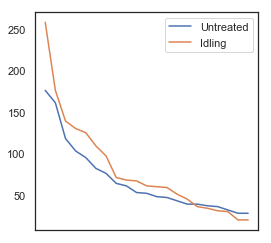

In [4]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [51]:
max(U.barcode_counts(IDs=U.top_barcodes(top20)))

176

In [52]:
max(I.barcode_counts(IDs=U.top_barcodes(top20)))

258

In [5]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Perform PCA on each dataset to prime DRs

In [6]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 16.3 s, sys: 2.41 s, total: 18.7 s
Wall time: 12.8 s


In [17]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 17.1 s, sys: 3.34 s, total: 20.5 s
Wall time: 14.9 s


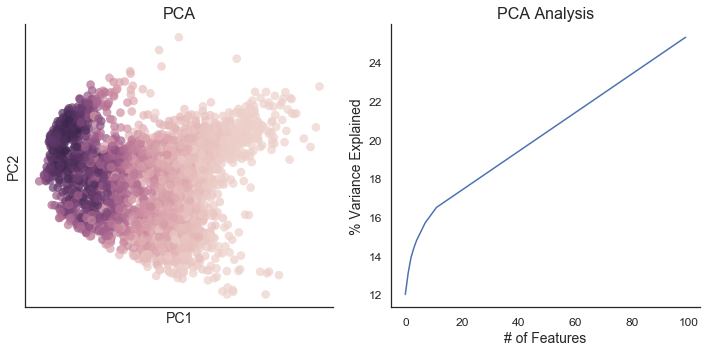

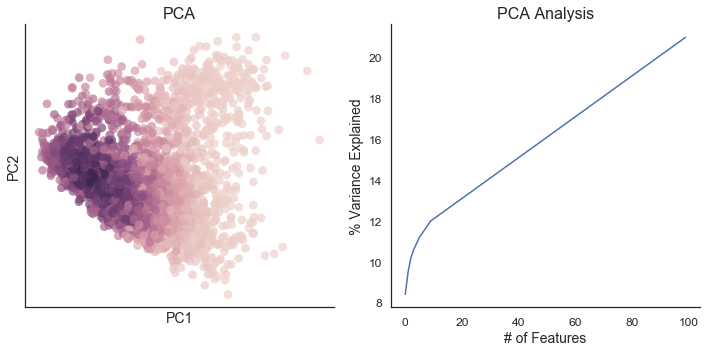

In [18]:
# visualize both PCAs
U_PCA.plot()
I_PCA.plot()

---
### t-SNE
Primed with 100-component PCA. FIt-SNE implementation.

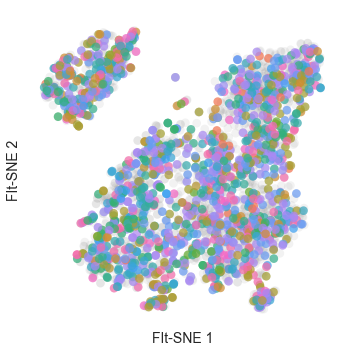

CPU times: user 979 ms, sys: 109 ms, total: 1.09 s
Wall time: 20.3 s


In [9]:
%%time 
U_FItSNE = fcc_FItSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_FItSNE.plot_barcodes(ranks=selected_codes)

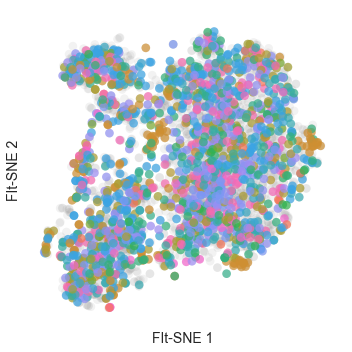

CPU times: user 1.26 s, sys: 117 ms, total: 1.37 s
Wall time: 23.6 s


In [19]:
%%time 
I_FItSNE = fcc_FItSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_FItSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

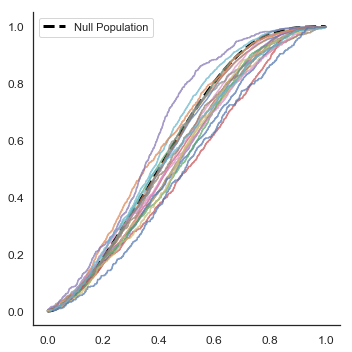

CPU times: user 32.1 s, sys: 1.03 s, total: 33.1 s
Wall time: 32.9 s


In [48]:
%%time
U_out = compare_barcode_distances(obj=U_FItSNE, barcodes=selected_codes)

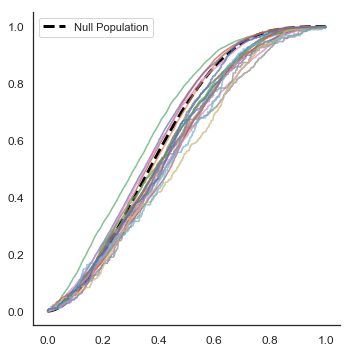

CPU times: user 50.5 s, sys: 1.85 s, total: 52.3 s
Wall time: 52.6 s


In [47]:
%%time
I_out = compare_barcode_distances(obj=I_FItSNE, barcodes=selected_codes)

In [55]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_FItSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min 9s, sys: 6.95 s, total: 4min 16s
Wall time: 4min 51s


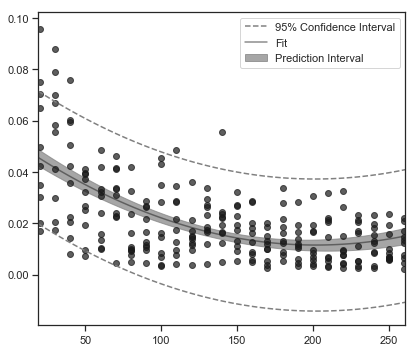

In [59]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=2)

Do the same as above for __Idling__ dataset

In [60]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_FItSNE, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 28s, sys: 14.6 s, total: 9min 42s
Wall time: 42min 37s


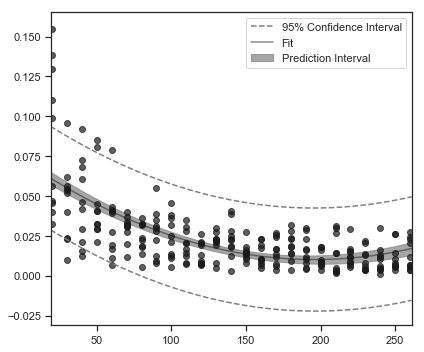

In [61]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=2)

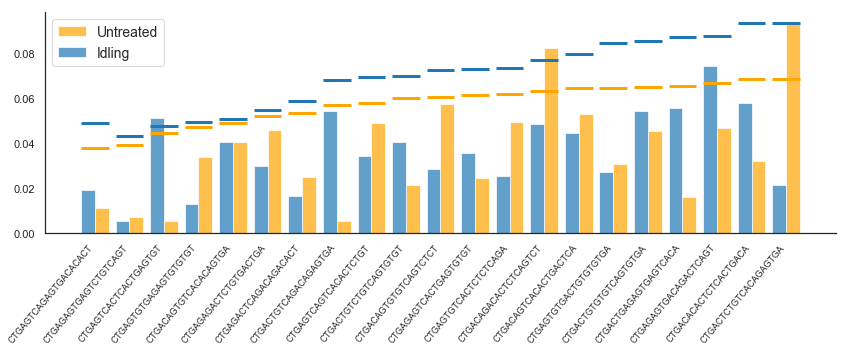

In [62]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### UMAP
Primed with 100-component PCA. 

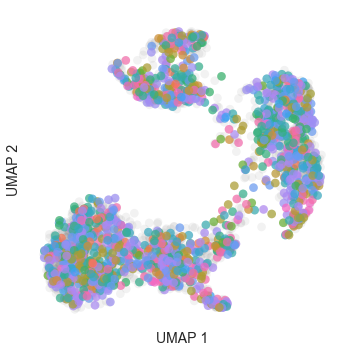

CPU times: user 14.1 s, sys: 884 ms, total: 15 s
Wall time: 15.1 s


In [63]:
%%time 
U_UMAP = fcc_UMAP(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_UMAP.plot_barcodes(ranks=selected_codes)

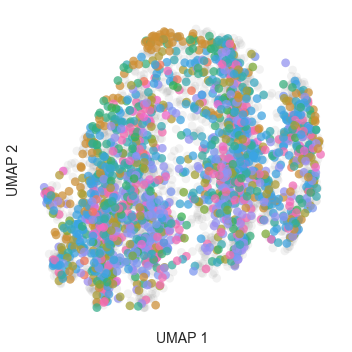

CPU times: user 9.98 s, sys: 538 ms, total: 10.5 s
Wall time: 10.1 s


In [64]:
%%time 
I_UMAP = fcc_UMAP(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_UMAP.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

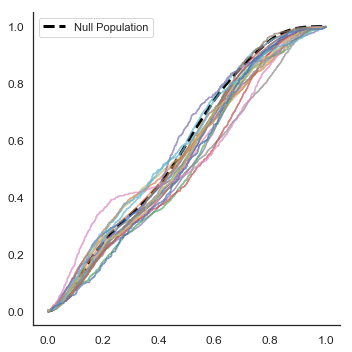

CPU times: user 32.2 s, sys: 1.17 s, total: 33.3 s
Wall time: 33.3 s


In [65]:
%%time
U_out = compare_barcode_distances(obj=U_UMAP, barcodes=selected_codes)

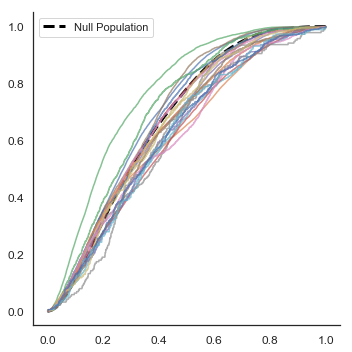

CPU times: user 50 s, sys: 1.88 s, total: 51.9 s
Wall time: 51.9 s


In [66]:
%%time
I_out = compare_barcode_distances(obj=I_UMAP, barcodes=selected_codes)

In [67]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 57s, sys: 6.21 s, total: 4min 4s
Wall time: 4min 4s


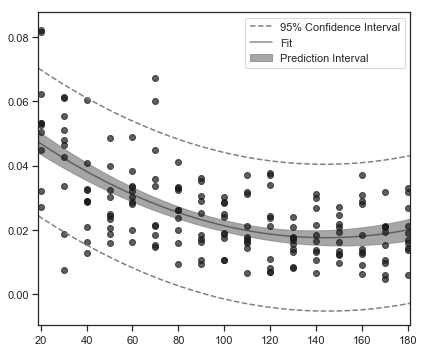

In [68]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=2)

Do the same as above for __Idling__ dataset

In [69]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_UMAP, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 20s, sys: 14.1 s, total: 9min 34s
Wall time: 40min 58s


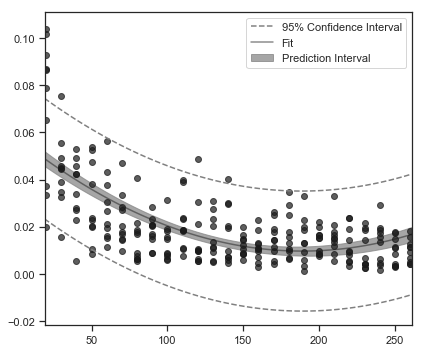

In [70]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=2)

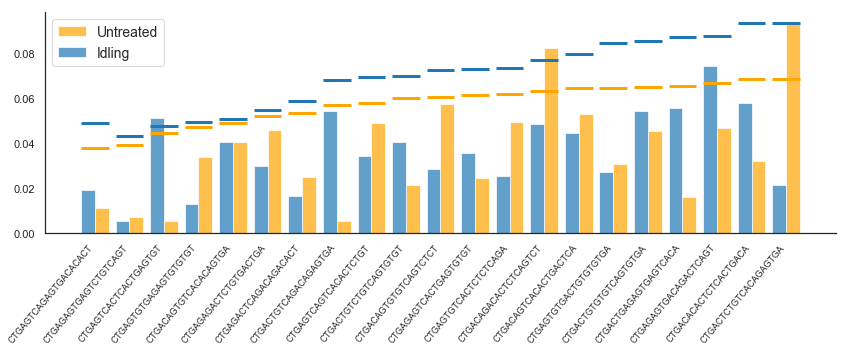

In [62]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()